# scalar testing

In [1]:
import os,sys
#sys.path.append(os.path.abspath('../'))
sys.path

['/Users/brucecottman/Documents/PROJECTS/paso/tests/pre',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python37.zip',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python3.7',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python3.7/lib-dynload',
 '',
 '/Users/brucecottman/.local/lib/python3.7/site-packages',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python3.7/site-packages',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python3.7/site-packages/aeosa',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python3.7/site-packages/IPython/extensions',
 '/Users/brucecottman/.ipython']

In [2]:
import numpy as np
import pytest
from sklearn.base import BaseEstimator, TransformerMixin


In [3]:
from category_encoders.utils import get_obj_cols, convert_input

In [4]:
from paso.base import get_paso_log

In [5]:
from paso.pre.scale import  __ScalerDict__,BoxCoxScaler , LambertScaler
__ScalerDict__

{'StandardScaler': sklearn.preprocessing.data.StandardScaler,
 'MinMaxScaler': sklearn.preprocessing.data.MinMaxScaler,
 'Normalizer': sklearn.preprocessing.data.Normalizer,
 'MaxAbsScaler': sklearn.preprocessing.data.MaxAbsScaler,
 'RobustScaler': sklearn.preprocessing.data.RobustScaler,
 'QuantileTransformer': sklearn.preprocessing.data.QuantileTransformer,
 'BoxCoxScaler': paso.pre.scale.BoxCoxScaler,
 'LambertScaler': paso.pre.scale.LambertScaler}

# Compare the effect of different scalers on data with Gauusians with heavy tails

## General

In [6]:
__author__ = 'BruceCottman'
__author__

'BruceCottman'

In [7]:
!conda list

# packages in environment at /Users/brucecottman/anaconda3/envs/paso:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
absl-py                   0.7.0                    pypi_0    pypi
alabaster                 0.7.12                   py37_0  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.6                    py37_0  
anaconda-project          0.8.2                    py37_0  
appnope                   0.1.0                    py37_0  
appscript                 1.0.1            py37h1de35cc_1  
asn1crypto                0.24.0                   py37_0  
astor                     0.7.1                    pypi_0    pypi
astroid                   2.1.0                    py37_0  
astropy                   3.1              py37h1de35cc_0  
atomicwrites              1.2.1                    py37_0  
attrdict                  2.0.1                    pypi_0    pypi
att

## **Note Outliers/Target; Gaussian with heavy tail**

    **Rank-Gaussian**
    - The method comes from Michael Jahrer
    - The idea is to first make the distribution uniform by rank transforming the data. Then you apply the inverse of the CDF for a normal. This results in very gaussian looking empirical data, but it has some drawbacks.
    - One drawback of this approach is that the first step, the empirical copula transform, is not a smooth transformation. Furthermore, inverting this transformation can only be done in a kind of piecemeal approximate way which is not yet implemented.

**Note Outliers/Target; Gaussian with heavy tail**
- use log or log1p (if needed to create Gaussian with heavy tail) and then **BoxCox** or **Lambert**
-  regression often assumes Gaussian errors;
- - regression with Cauchy error
- pattern recognition for images often model noise as a Gaussian random field 
- - denoising images for α-stable noise 
-  data/noise often exhibits asymmetry and heavy tails; 
- - wind speed data human dynamics. Internet traffic data, etc.
-  many time series models are based on Gaussian white noise
- - forecasting long memory processes
- - ARMA modeling of electricity loads with hyperbolic noise 
- - financial data and speech signals which almost exclusively exhibit heavy tails
- CNN work best with Guassian sjapes
- clip any remaining outliers???

## imports

In [8]:
import pandas as pd
import copy, random
import numpy as np
from numba import jit

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.utils import get_obj_cols, convert_input
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.data import QuantileTransformer
import sklearn.preprocessing.data as skpr


Level	Numeric value
-   CRITICAL	50
-    ERROR	40
-    WARNING	30
-    INFO	20
-    DEBUG	10
-    NOTSET	0

In [10]:
logger = get_paso_log()

In [11]:
logger.setLevel('DEBUG'.upper())
logger.getEffectiveLevel()

10

In [12]:
from __future__ import print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
import probscale
import seaborn as sns
from scipy.stats import probplot
import statsmodels.api as sm

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib

## Input  Datasets

Continuous features can exhibit a wide range of distributional characteristics, including near-Gaussian, strongly asymmetric, light- or heavy-tailed, multi-moda

Catagorical features  can be  either ordered, or unordered. Catagorical features are not covered here.

### Boston Dataset

In [13]:
from sklearn.datasets import load_boston
boston = load_boston()

logger.info(boston.feature_names)
logger.info(boston.DESCR)
City = pd.DataFrame(boston.data, columns = boston.feature_names )
City = City[['CRIM', 'INDUS','NOX','TAX','B']]
City['MEDV'] = boston.target
logger.info(City.shape)
logger.info(City.columns)

A dataset that illustrates the range of distributional behavior is the Boston Boston dataframe.  This dataframe includes 14 numerical variables that characterize 506 suburban housing tracts in the Boston area: 12 of these variables have class “numeric” and the remaining two have class “integer”.  

-  the distribution of crim is very asymmetric with an extremely heavy right tail;
- the distribution of lstat is also clearly asymmetric but far less so;
- the distribution of rm appears to be almost Gaussian; 
- the distribution of zn appears to be tri-modal, mostly concentrated around zero, but with clear secondary peaks at around 20 and 80.

### Housing Dataset

- Feature 0 (median income in a block) and feature 5 (number of households) of
the `California housing dataset
<http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html>`_ have very
different scales and contain some very large outliers. These two
characteristics lead to difficulties to visualize the data and, more
importantly, they can degrade the predictive performance of many machine
learning algorithms. Unscaled data can also slow down or even prevent the
convergence of many gradient-based estimators.
- Indeed many estimators are designed with the assumption that each feature takes
values close to zero or more importantly that all features vary on comparable
scales. In particular, metric-based and gradient-based estimators often assume
approximately standardized data (centered features with unit variances). A
notable exception are decision tree-based estimators that are robust to
arbitrary scaling of the data.

In [14]:
from sklearn.datasets import fetch_california_housing
print(__doc__)
dataset = fetch_california_housing()
X_full, y_full = dataset.data, dataset.target

# Take only 2 features to make visualization easier
# Feature of 0 has a long tail distribution.
# Feature 5 has a few but very large outliers.
logger.info(dataset.data.shape)
logger.info(dataset.feature_names)
logger.info(dataset.DESCR) 
Housing = pd.DataFrame(dataset.data, columns = dataset.feature_names )
Housing = Housing[['MedInc', 'HouseAge', 'AveRooms'
                   , 'AveBedrms', 'Population', 'AveOccup']]
logger.info(Housing.shape)
logger.info(Housing.columns)

Automatically created module for IPython interactive environment


### Hip_m Dataset

hip_m=np.genfromtxt('HIP_MEN_chr_pos_rs_pval.txt', dtype=None)
hip_m= pd.DataFrame(hip_m[['f0','f1','f2','f3']])
Hip_m= hip_m
hip_m= hip_m[['f1','f3']]
logger.info(hip_m.shape)
logger.info(hip_m.head())

## __ScalerDict__


- We use different scalers, transformers, and normalizers to tranform feature data as near as possible a Guassian shape.

- - Scalers are linear (or more precisely affine) transformers and differ from each
other in the way to estimate the parameters used to shift and scale each
feature.

- - ``QuantileTransformer`` provides a non-linear transformation in which distances
between marginal outliers and inliers are shrunk.

- - Unlike the previous transformations, normalization refers to a per sample
transformation instead of a per feature transformation.

In [15]:
logger.info(display(__ScalerDict__))

{'StandardScaler': sklearn.preprocessing.data.StandardScaler,
 'MinMaxScaler': sklearn.preprocessing.data.MinMaxScaler,
 'Normalizer': sklearn.preprocessing.data.Normalizer,
 'MaxAbsScaler': sklearn.preprocessing.data.MaxAbsScaler,
 'RobustScaler': sklearn.preprocessing.data.RobustScaler,
 'QuantileTransformer': sklearn.preprocessing.data.QuantileTransformer,
 'BoxCoxScaler': paso.pre.scale.BoxCoxScaler,
 'LambertScaler': paso.pre.scale.LambertScaler}

## Plot Distribution Defintions

### SeabornFig2Grid

In [16]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

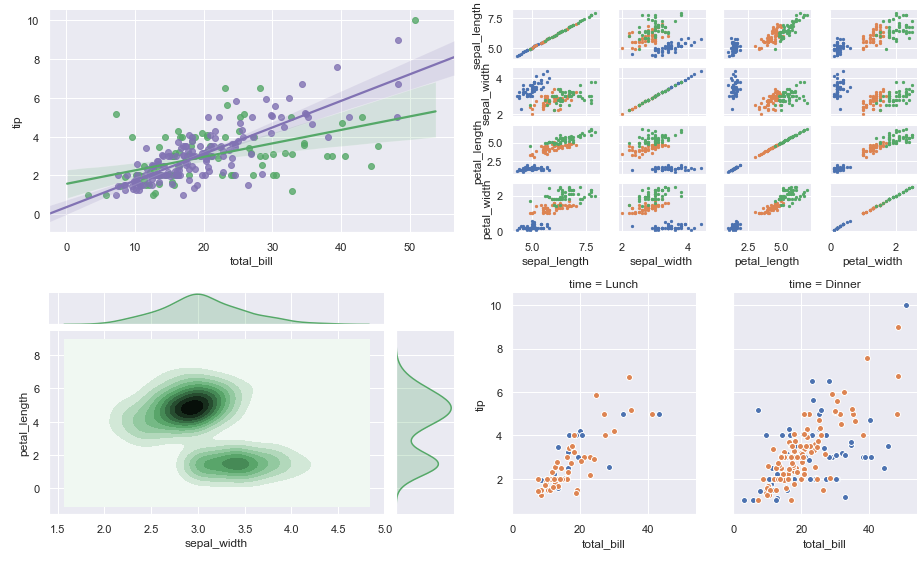

In [17]:
#import SeabornFig2Grid as sfg


sns.set()

iris = sns.load_dataset("iris")
tips = sns.load_dataset("tips")

# An lmplot
g0 = sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips, 
                palette=dict(Yes="g", No="m"))
# A PairGrid
g1 = sns.PairGrid(iris, hue="species")
g1.map(plt.scatter, s=5)
# A FacetGrid
g2 = sns.FacetGrid(tips, col="time",  hue="smoker")
g2.map(plt.scatter, "total_bill", "tip", edgecolor="w")
# A JointGrid
g3 = sns.jointplot("sepal_width", "petal_length", data=iris,
                   kind="kde", space=0, color="g")


fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(2, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[3])
mg3 = SeabornFig2Grid(g3, fig, gs[2])

gs.tight_layout(fig)
#gs.update(top=0.7)

plt.show()


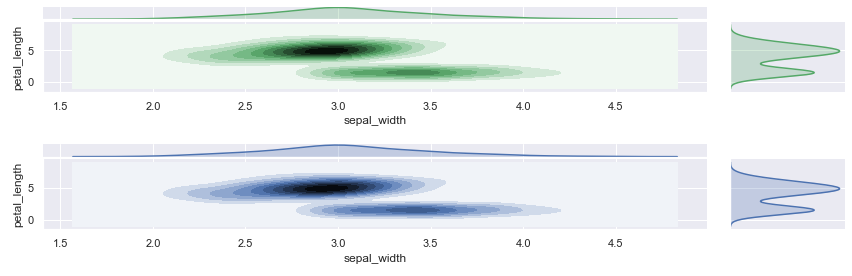

In [18]:
sns.set()

iris = sns.load_dataset("iris")
tips = sns.load_dataset("tips")

g2 = sns.jointplot("sepal_width", "petal_length", data=iris,
                   kind="kde", space=0, color="g")
g3 = sns.jointplot("sepal_width", "petal_length", data=iris,
                   kind="kde", space=0, color="b")


fig = plt.figure(figsize=(4*3,4))
gs = gridspec.GridSpec(2, 1)

#mg0 = SeabornFig2Grid(g0, fig, gs[0])
#mg1 = SeabornFig2Grid(g1, fig, gs[1])
#mg2 = SeabornFig2Grid(g2, fig, gs[3])
mg0 = SeabornFig2Grid(g2, fig, gs[0])
mg1 = SeabornFig2Grid(g3, fig, gs[1])
#mg2 = SeabornFig2Grid(g3, fig, gs[2])
gs.tight_layout(fig)
#gs.update(top=0.7)

plt.show()

### ppqqp_plot

In [19]:
def ppqqp_plot(X,name,sze=100,dist=None):
    '''
    3 plots 
    1. Percentile, a.k.a. P-P plot
    2 .Quantile, a.k.a. Q-Q plot (normal distribution)
    3. Probability, a.k.a. Prob Plot
    quick and dirty no numpy or other dist checking
    - X must be a pandas series
    - name: label name
    - size: (default: 100) is sample size of X 
    - dist: (default: none)  When using quantile or probability scales,
    you can pass a distribution from the scipy.stats module
    to the probplot function. When a distribution is not provided 
    to the dist parameter, a standard normal distribution is used.
    - return: boolean of sucess
    '''

    logger.debug('ppqqp_plot:')        
    if not ((X.dtype == np.int) or (X.dtype == np.float)):
        # not numeric
        logger.error('ppqqp was passed a distrubtion not numeric but of type: {})'.format(X.dtype))
        return(False)
    if type(X) == np.ndarray:
        if len(X) > sze: X = np.random.choice(X,sze)
    elif type(X) == pd.core.series.Series:
        if len(X) > sze: X = X.sample(sze)
    else:
        logger.error('ppqqp was passed a distrubtion not numeric but of type: {})'.format(X.dtype))
        return(False)
    ax = [0,1,3]
    fig, (ax[0], ax[1],ax[2]) = plt.subplots(figsize=(12, 4), ncols=3)
    gp = probscale.probplot(X, ax=ax[0], plottype='pp', bestfit=True,
                             problabel='Percentile', datalabel=name,
                             scatter_kws=dict(label=name),
                             line_kws=dict(label='Best Fit line'))
    fig = probscale.probplot(X, ax=ax[1], plottype='qq', bestfit=True, dist=dist,
                             problabel='Standard Normal Quantiles', datalabel=name,
                             scatter_kws=dict(label=name),
                             line_kws=dict(label='Normal QQ line'))
    fig = probscale.probplot(X, ax=ax[2], plottype='prob', bestfit=True,dist=dist,
                             problabel='Standard Normal Probalities', datalabel=name,
                             scatter_kws=dict(label=name),
                             line_kws=dict(label='Normal Probalities line'))
    ax[0].legend(loc='upper left');ax[1].legend(loc='upper left');ax[2].legend(loc='upper left')
    return(True)

### dualplot

In [20]:
def dualplot(dist,ytest):
    logger.debug('dualplot:')
    df = pd.DataFrame({'theory': dist,'actual': ytest})
    fig = plt.figure(figsize=(4,4))
    gp = sns.jointplot('actual', 'theory', df, stat_func=None, kind='hex')
    return(gp)

### Plot_Distribution_c

In [22]:
#side effect is a plot, nothing to save
# no state to save
#maybe save plot in (or X) in future version
from matplotlib import colors as mcolors

class Plot_Distribution_c(object):
    def __init__(self,label='',dist_name=''
                 ,title='Distribution',*args,**kwargs):
        super().__init__()
        self.title = title
        self.label = label
        self.dist_name = dist_name
        self.color_list = list(mcolors.CSS4_COLORS.keys())[51:100]
    
    def fit(self, X_o,X):
        logger.debug('Plot_Distribution_c fit:')
        return self

# X_o: orginal
# X ->  X = f(X_o)
    def transform(self, X_o,X):
        logger.debug('Plot_Distribution_c transform:')
        for feat in list(X_o.columns):  # assume df,fix later
            vth = list(X_o.columns).index(feat)
            self.dist_name = ' '+feat
            dualplot(X_o[feat],X[:,vth])
            ppqqp_plot(X[:,vth],self.label+self.dist_name)
        return self
    
    def fit_transform(self, X_o,X):
        return((self.fit(X_o,X)).transform(X_o,X))

    def load(self, filepath):
        return self

    def persist(self, filepath):
        pass

### fooplot definitions

In [23]:
def fooplot(dnames,scaler_list,size):

    for dname,args in dnames:
        for scalar in scaler_list:
            logger.debug('{}  {}:    {} '.format(scalar,args,dname))
            if args == 'none': 
                dist = StatDistributionDict[dname](size=size)
            else: 
                dist = StatDistributionDict[dname](*args,size=size)
            try: 
                gp = [0,1,2,3]
                sns.set()
                ytest = __ScalerDict__[scalar]().fit_transform(dist[:,np.newaxis])
                gp0 = dualplot(dist,ytest)
                ppqqp_plot(ytest,scalar+' '+ dname)
            except: pass
            plt.show()

In [24]:
def fooplot2(df,dnames,scaler_list,size):
    for dname in dnames:
        for scalar in scaler_list:
            try:
                dist = df[dname].values
                ytest = __ScalerDict__[scalar]().fit_transform(dist[:,np.newaxis])
                dualplot(dist,ytest)
                ppqqp_plot(ytest,scalar+dname)
            except: pass


## Statisical Distibutions Tests


In [25]:
import scipy
StatDistributionDict = {}

print('\nDistribution with no  attribute rvs method \n ===============================================')
for nth,d in enumerate(scipy.stats.__all__):
    try:
        StatDistributionDict[d] = eval('scipy.stats.'+d+'.rvs')
    except:
        logger.debug('{} {}'.format(nth,d))

print('\nDistribution attribute rvs method \n ========================================')
for nth,d in enumerate(StatDistributionDict.keys()):
    logger.info('{} {}'.format(nth,d))


Distribution with no  attribute rvs method 

Distribution attribute rvs method 


###  Scalar Transform .vs. Original Distribution Joint Plot

#### Standard Distibutions

In [26]:
size = 10000
dist = StatDistributionDict['cauchy'](size=size)

In [27]:
__ScalerDict__['LambertScaler']

paso.pre.scale.LambertScaler

In [28]:
dnames = [['beta',[2.0,1.0]],['alpha',[0.75]]
          ,['uniform','none'],['cauchy','none']
          ,['ksone',[1000]],['boltzmann',[1.4, 19]]
          ,['laplace',[3.0]],['tukeylambda',[3.0]]
          ,['dweibull',[3.0]],['chi2',[3.0]]
          ,['exponnorm',[1]],['norm','none']]

scaler_list = ['BoxCoxScaler','LambertScaler'
               ,'StandardScaler','MinMaxScaler']
size = 10000
fooplot(dnames,scaler_list,size)


#### Housing

In [29]:
df = Housing
dnames = list(df.columns)
scaler_list = ['BoxCoxScaler','LambertScaler'
               ,'StandardScaler','MinMaxScaler']
size = 10000

fooplot2(df,dnames,scaler_list,size)

- every transform has problems last bin of HOUSEAGE. This last could be a clip, which could be modeled as same distbution with a width of 50 (parmeterize year extension number) An experiment for another day
- MINMAX probably does best on AVGBEDRMS at transforming into Gaussian
- BOOXCOX does well on AVEROCCUP!!!!!

#### City

In [30]:
df = City
dnames = list(df.columns)

scaler_list = ['BoxCoxScaler','LambertScaler'
               ,'StandardScaler','MinMaxScaler']

size = 10000

fooplot2(df,dnames,scaler_list,size)

- 'BoxCoxScaler','LambertScaler' do best on the continuous features

#### Hip male

df = hip_m
dnames = list(df.columns)

scaler_list = ['BoxCoxScaler','LambertScaler'
               'StandardScaler','MinMaxScaler']

size = 10000

fooplot2(df,dnames,scaler_list,size)

#### Conclusions

- BoxCox is better than Lambert at transforming into Gaussian (halfgennorm,chisq
- - wont work on negative values (Cauchy,laplace
- Lambert is best at bringing right or left tails towards center (by about 2 or more stds) and best at not-perturbing (changing) balanced distributions (uniform,dweibull)
- although Standard and Robust are even better at not-perturbing any distribution

- use BoxCox to transform to Gaussian
- use Lambert for distributions with outliers to transform to more centered (less skewnn)
- use Standard to put any feature on a standard scale

#  Steps

Hip_m_o = Hip_m.copy()
data_Hip_m = {
    'input': {
        'features': Hip_m,
        'features_o': Hip_m_o
    }
}

## LambertScaler -Step Testing

In [ ]:
LambertScaler_step = Step(name='Steppy_Scaler_L',
               transformer=S_Scaler('LambertScaler'),
               input_data=['input'],
               adapter=Adapter({
                   'X': E('input','features_o')
               }),
               experiment_directory=EXPERIMENT_DIR,
                is_trainable=True,
                force_fitting=True)

In [ ]:
LambertScaler_step.fit_transform(data_Housing)['X'][:,0][:,np.newaxis].shape

In [ ]:
import graphviz
#.LambertScaler_step

## StandardScaler - Step Testing 

In [ ]:
StandardScaler_step = Step(name='Steppy_Scaler_S',
               transformer=S_Scaler('StandardScaler'),
               input_data=['input'],
               adapter=Adapter({
                   'X': E('input','features_o')
               }),
               experiment_directory=EXPERIMENT_DIR,
                       is_trainable=True,
                       force_fitting=True)

In [ ]:
StandardScaler_step.fit_transform(data_Housing)['X'][:,0][:,np.newaxis].shape

## BoxCoxEncoder - Step Testing -FAIL

In [ ]:
# should fail
try:
    n = 'BoxCoxEncoder'
    e = Steppy_Scaler(n,verbose=True)
except:
    print('BoxCoxEncoder ***error*** should be BoxCoxScaler')


##  Lots of Scale Steps Test

In [ ]:
scaler_list = ['BoxCoxScaler','LambertScaler','StandardScaler','MinMaxScaler']
Scale_steps = [Step(name='S_Scaler_{}'.format(scaler),
                 transformer=S_Scaler(scaler),
                 input_data=['input'],
                 adapter=Adapter({
                       'X': E('input','features')
                }),    
               experiment_directory=EXPERIMENT_DIR,
                is_trainable=True,
                force_fitting=True)
            for nth, scaler in enumerate(scaler_list)]

In [ ]:
Scale_steps[1].fit_transform(data_Housing)['X'][:,1][:,np.newaxis].shape

In [ ]:
Scale_steps[0].name[14:]

In [ ]:
pc = Plot_Distribution_c()
feat = 'MedInc'
x_o = Housing
ytest = Scale_steps[0].fit_transform(data_Housing)['X']
pc.label = Scale_steps[0].name[14:]
pc.transform(x_o,ytest)


# Plot Testing of Scalers

## Plot_Gaussian_step

In [ ]:
#color_list = list(mcolors.CSS4_COLORS.keys())[51:100]
Plot_Gaussian_step \
    = [Step(name='Plot_Gaussian_{}'.format(astep.name),
           transformer=Plot_Distribution_c(label=astep.name[14:]),
           input_steps=[astep], 
           input_data=['input'],
            adapter=Adapter({
                   'X_o': E('input','features_o'),
                   'X': E(astep.name,'X')
            }),
            experiment_directory=EXPERIMENT_DIR,
           is_trainable=True,
           force_fitting=True)
            for nth, astep in enumerate(list(Scale_steps))]



## Plot_Gaussian_step Step Test

### Cauchy Step Input

In [ ]:
dname ='cauchy'
dist = StatDistributionDict[dname](size=1000)

In [ ]:
data_Dist = {
    'input': {
        'features': dist
    }
}
#Plot_Gaussian_step[0]

### Housing Plot_Gaussian_step

In [ ]:
for Plot_Gaussian_step_nth in Plot_Gaussian_step:
    Plot_Gaussian_step_nth.fit_transform(data_Housing)

### City Plot_Gaussian_step

In [ ]:
for Plot_Gaussian_step_nth in Plot_Gaussian_step:  
        Plot_Gaussian_step_nth.fit_transform(data_City)

### Hip_m Plot_Gaussian_step

for Plot_Gaussian_step_nth in Plot_Gaussian_step:  
    try: Plot_Gaussian_step_nth.fit_transform(data_Hip_m)
    except: pass

# References

## Compare the effect of different scalers on data with outliers¶
- Author:  Raghav RV <rvraghav93@gmail.com>
-           Guillaume Lemaitre <g.lemaitre58@gmail.com>
-          Thomas Unterthiner
-  License: BSD 3 clause
- http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

## Better ways to do One Hot Encoding
- by Tukey
- http://tukeys.blogspot.com/2017/05/better-ways-to-do-one-hot-encoding.html

## 1st place with representation learning (RankGauss)
- by Michael Jahrer
- https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629#260408

## Preparing continuous features for neural networks with GaussRank
- by y Zygmunt Z. 
- http://fastml.com/preparing-continuous-features-for-neural-networks-with-rankgauss/
- https://github.com/zygmuntz/gaussrank

## Plotting Class: SeabornFig2Grid
- https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot

## A closer look at probability plots
- https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html#overview

## Spacing measures: heterogeneity in numerical distributions
- http://exploringdatablog.blogspot.com/2012/09/spacing-measures-heterogeneity-in.html